# [自然语言处理入门](https://github.com/FudanNLP/nlp-beginner)

## 任务一：基于机器学习的文本分类

实现基于logistic/softmax regression的文本分类

1. 参考
   1. [文本分类](文本分类.md)
   2. 《[神经网络与深度学习](https://nndl.github.io/)》 第2/3章
2. 数据集：[Classify the sentiment of sentences from the Rotten Tomatoes dataset](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)
3. 实现要求：NumPy
4. 需要了解的知识点：

   1. 文本特征表示：Bag-of-Word，N-gram
   2. 分类器：logistic/softmax  regression，损失函数、（随机）梯度下降、特征选择
   3. 数据集：训练集/验证集/测试集的划分
5. 实验：
   1. 分析不同的特征、损失函数、学习率对最终分类性能的影响
   2. shuffle 、batch、mini-batch 
6. 时间：两周

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/NaturalLanguageProcessing/nlp-beginner/task-1

basic-text-classification.ipynb  text-classification-nn.ipynb
data				 text-classification-rnn.ipynb
text-classification-cnn.ipynb


### 卷积神经网络

In [ ]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# 读取 TSV 文件并转成 Dataset
def load_dataset(path):
  data = pd.read_csv(path, delimiter='\t', encoding='utf-8')
  return tf.data.Dataset.from_tensor_slices((data['Phrase'].values, data['Sentiment'].values))

Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [ ]:
TRAIN_FILE_PATH='/content/drive/MyDrive/NaturalLanguageProcessing/nlp-beginner/task-1/data/train.tsv'

# 读取文件
dataset = load_dataset(TRAIN_FILE_PATH)
dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# 准备数据
data = []
label = []
for feat, targ in dataset.take(156000):
  data.append(tfds.as_numpy(feat))
  if tfds.as_numpy(targ) > 2:
    label.append(1)
  else:
    label.append(0)

In [ ]:
# 划分训练集与测试集
train_dataset = tf.data.Dataset.from_tensor_slices((data[:150000], label[:150000]))
test_dataset = tf.data.Dataset.from_tensor_slices((data[150000:], label[150000:]))

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
2344/2344 [==============================] - 36s 15ms/step - loss: 0.5550 - accuracy: 0.7477 - val_loss: 0.4631 - val_accuracy: 0.7995
Epoch 2/5
2344/2344 [==============================] - 35s 15ms/step - loss: 0.4468 - accuracy: 0.8029 - val_loss: 0.4558 - val_accuracy: 0.8094
Epoch 3/5
2344/2344 [==============================] - 35s 15ms/step - loss: 0.4313 - accuracy: 0.8115 - val_loss: 0.4487 - val_accuracy: 0.8083
Epoch 4/5
2344/2344 [==============================] - 35s 15ms/step - loss: 0.4208 - accuracy: 0.8179 - val_loss: 0.4508 - val_accuracy: 0.8068
Epoch 5/5
2344/2344 [==============================] - 35s 15ms/step - loss: 0.4089 - accuracy: 0.8244 - val_loss: 0.4586 - val_accuracy: 0.8047


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

94/94 [==============================] - 0s 4ms/step - loss: 0.4553 - accuracy: 0.8123
Test Loss: 0.4553470015525818
Test Accuracy: 0.812333345413208


(0.0, 0.5176220148801803)

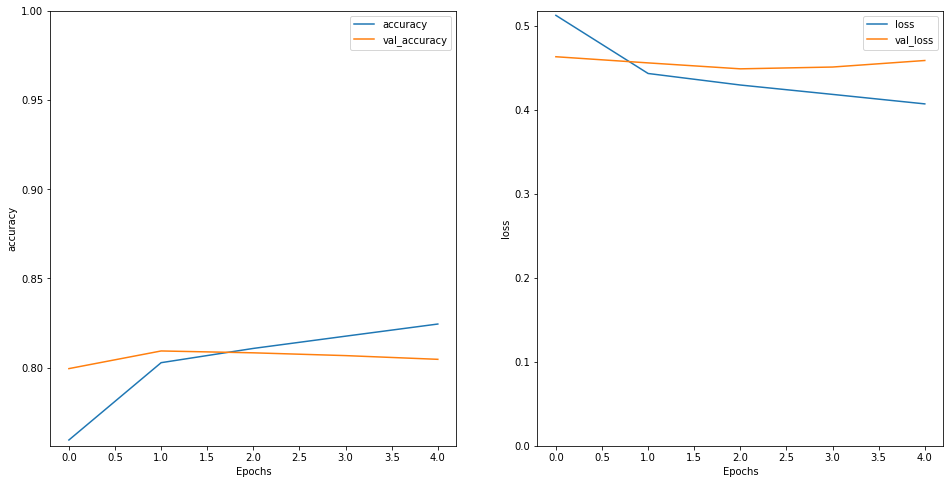

In [14]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)